In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
# %cd CD_Circuit/

import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
import operator

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals, compare_same
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from pyfunctions.wrappers import Node, AblationSet

Result = collections.namedtuple('Result', ('ablation_set', 'score'))


KeyboardInterrupt: 

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [ ]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
mean_acts = torch.mean(attention_outputs, dim=0)
old_shape = mean_acts.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
mean_acts = mean_acts.view(new_shape)
mean_acts.shape

In [ ]:

# source_list = [Node(0, 0, 0), Node(1, 1, 1)]
# target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
# out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

## Algorithm A (the one found in the current paper)

### Run on last sequence position specifically

In [6]:
import functools
ranges = [
        [layer for layer in range(12)],
        [input_shape[1] - 2],
        # [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]

# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


### Ablate all heads at once

In [34]:
import functools
'''
ranges = [
        [layer for layer in range(12)],
        # [input_shape[1] - 2],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]
'''
ablation_sets = []
for layer in range(12):
    for seq_idx in range(15):
        ablation_sets.append(tuple(Node(layer, seq_idx, x) for x in range(12)))
# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

Running inputs 0 to 64 (of 180)
Running inputs 64 to 128 (of 180)
Running inputs 128 to 180 (of 180)


### Do the normal thing and ablate at all individual spots

In [6]:
import functools

ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

target_nodes = []

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

running input 0
running input 1600


In [1]:
def compute_logits_decomposition_scores(out_decomps):
    logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
    io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
    s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
    full_score = np.abs(io_logit - s_logit)
    assert(full_score > 0) # this needs to be replaced with a check higher in the pipeline; GPT2 succeeds at this like 99%+ of the time but not always

    results = []
    
    for decomp in out_decomps:
        rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
        rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
        score = rel_io_logit - rel_s_logit
        norm_score = score / full_score
        # predicted_probs = torch.nn.functional.softmax(torch.Tensor(decomp.rel[0][-2])).cpu().numpy()
        # score = -np.log(predicted_probs[ioi_dataset.io_tokenIDs[0]]) # KL divergence from one-hot distribution
        results.append(Result(decomp.ablation_set, score))
    results.sort(key=operator.attrgetter('score'), reverse=True)
    return results

In [2]:
results = compute_logits_decomposition_scores(out_decomps)

for result in results[:10]:
    print(result)

NameError: name 'out_decomps' is not defined

In [115]:
'''
for result in results[:20]:
    print(result.ablation_set[0], result.score)
'''
'''
for result in results:
    if result.ablation_set[0].layer_idx == 9 and result.ablation_set[0].attn_head_idx == 9:
        print(result.ablation_set[0], result.score)
'''
for result in results:
    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or \
        result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:
            print(result.ablation_set[0], result.score)


Node(layer_idx=8, sequence_idx=14, attn_head_idx=6) 0.12152111
Node(layer_idx=8, sequence_idx=14, attn_head_idx=10) 0.0822009
Node(layer_idx=7, sequence_idx=14, attn_head_idx=9) 0.07783296
Node(layer_idx=8, sequence_idx=4, attn_head_idx=10) 0.07362208
Node(layer_idx=7, sequence_idx=4, attn_head_idx=3) 0.071159504
Node(layer_idx=7, sequence_idx=3, attn_head_idx=3) 0.07108998
Node(layer_idx=7, sequence_idx=4, attn_head_idx=9) 0.06943682
Node(layer_idx=7, sequence_idx=3, attn_head_idx=9) 0.06770895
Node(layer_idx=7, sequence_idx=1, attn_head_idx=9) 0.06574008
Node(layer_idx=8, sequence_idx=4, attn_head_idx=6) 0.06536073
Node(layer_idx=7, sequence_idx=1, attn_head_idx=3) 0.06427851
Node(layer_idx=7, sequence_idx=2, attn_head_idx=9) 0.0599772
Node(layer_idx=7, sequence_idx=2, attn_head_idx=3) 0.057893638
Node(layer_idx=8, sequence_idx=2, attn_head_idx=10) 0.057380237
Node(layer_idx=8, sequence_idx=9, attn_head_idx=10) 0.0559245
Node(layer_idx=8, sequence_idx=2, attn_head_idx=6) 0.055904876


In [119]:
scores = [r.score for r in results if r.score > 0]
std_dev = np.std(scores)
mean = np.mean(scores)
print(std_dev, mean)

0.03560574 0.05491805


Text(0.5, 0, 'Contribution')

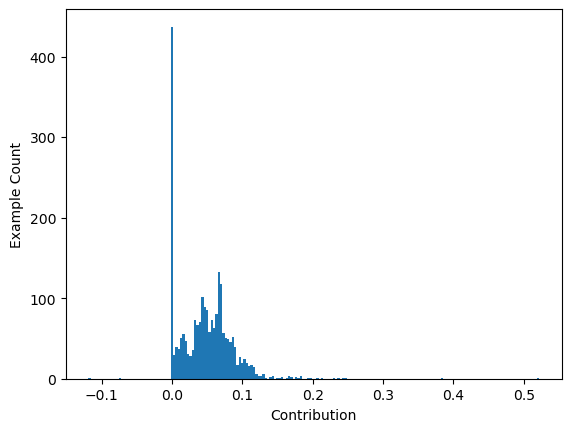

In [116]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=False, bins=192)
plt.ylabel('Example Count')
plt.xlabel('Contribution')

Text(0.5, 0, 'Contribution')

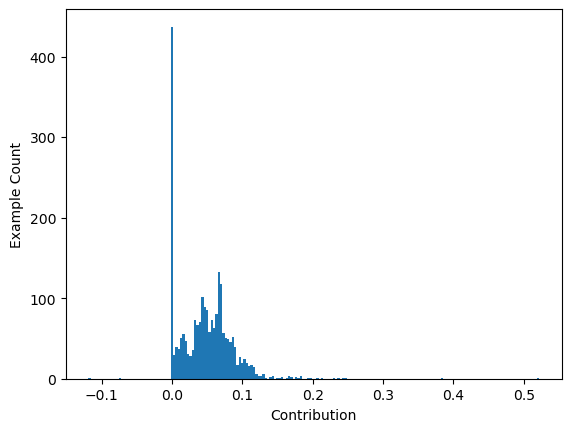

In [116]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=False, bins=192)
plt.ylabel('Example Count')
plt.xlabel('Contribution')

In [23]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):] #bisect does a binary search, returns idx of outlier_score
    return outliers




In [27]:
print(torch.cuda.memory_allocated(0)/1024/1024)
print(torch.cuda.memory_reserved(0)/1024/1024)
import gc
gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0)/1024/1024)
print(torch.cuda.memory_reserved(0)/1024/1024)



11498.65576171875
12060.0
882.81982421875
1212.0


In [19]:
# ioi_dataset.word_idx

In [ ]:
mean_acts_per_head = mean_acts.view(old_shape)
print(mean_acts_per_head.shape)
print(target_decomps[0].rels[0].shape)

torch.Size([12, 16, 12, 64])
torch.Size([1, 64])


In [ ]:
ioi_logits, ioi_cache = model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension

ioi_cache['blocks.' + '0' + '.attn.hook_z'][0][0][0].shape

torch.Size([64])

In [ ]:
results.sort(key=operator.attrgetter('score'), reverse=True)
results[:50]
for result in results:
    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or \
        result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:
        print(result.ablation_set[0], result.score)


Node(layer_idx=7, sequence_idx=2, attn_head_idx=3) tensor(2.8631, device='cuda:0')
Node(layer_idx=7, sequence_idx=2, attn_head_idx=9) tensor(2.5057, device='cuda:0')
Node(layer_idx=8, sequence_idx=2, attn_head_idx=10) tensor(2.3456, device='cuda:0')
Node(layer_idx=7, sequence_idx=3, attn_head_idx=3) tensor(2.1374, device='cuda:0')
Node(layer_idx=8, sequence_idx=14, attn_head_idx=6) tensor(2.0232, device='cuda:0')
Node(layer_idx=7, sequence_idx=14, attn_head_idx=9) tensor(1.5772, device='cuda:0')
Node(layer_idx=8, sequence_idx=10, attn_head_idx=10) tensor(1.5526, device='cuda:0')
Node(layer_idx=8, sequence_idx=14, attn_head_idx=10) tensor(1.4639, device='cuda:0')
Node(layer_idx=7, sequence_idx=3, attn_head_idx=9) tensor(1.2003, device='cuda:0')
Node(layer_idx=8, sequence_idx=2, attn_head_idx=6) tensor(1.1704, device='cuda:0')
Node(layer_idx=8, sequence_idx=10, attn_head_idx=6) tensor(1.1144, device='cuda:0')
Node(layer_idx=7, sequence_idx=11, attn_head_idx=9) tensor(0.9955, device='cuda

In [20]:
outliers_per_iter = []
results_per_iter = [results]

In [23]:
outliers = results[:2]

In [82]:
outliers = results[:2] # hardcoded first few N
outliers_per_iter.append(outliers)

In [77]:
# Now, find maximally relevant source nodes to target nodes

# TODO: this needs to be put in a loop to implement the "actual" algorithm, currently it's just for analysis
# results.sort(key=operator.attrgetter('score'), reverse=False)|
# iqr = interquartile_range(results)
# print(len(iqr))
# outliers = n_sigma_rule(results, n=0.5)
# print(len(outliers))

# results.sort(key=operator.attrgetter('score'), reverse=True)
outliers = results[:2] # hardcoded first few N
outliers_per_iter.append(outliers)
target_nodes = [r.ablation_set[0] for r in outliers] # here we assume that we only ever tried to ablate one node at once
print(target_nodes)
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(16)],
        # [ioi_dataset.word_idx['IO'][0]],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

[Node(layer_idx=1, sequence_idx=3, attn_head_idx=7), Node(layer_idx=1, sequence_idx=3, attn_head_idx=10)]
Running inputs 0 to 64 (of 2304)
Running inputs 64 to 128 (of 2304)
Running inputs 128 to 192 (of 2304)
Running inputs 192 to 256 (of 2304)
Running inputs 256 to 320 (of 2304)
Running inputs 320 to 384 (of 2304)
Running inputs 384 to 448 (of 2304)
Running inputs 448 to 512 (of 2304)
Running inputs 512 to 576 (of 2304)
Running inputs 576 to 640 (of 2304)
Running inputs 640 to 704 (of 2304)
Running inputs 704 to 768 (of 2304)
Running inputs 768 to 832 (of 2304)
Running inputs 832 to 896 (of 2304)
Running inputs 896 to 960 (of 2304)
Running inputs 960 to 1024 (of 2304)
Running inputs 1024 to 1088 (of 2304)
Running inputs 1088 to 1152 (of 2304)
Running inputs 1152 to 1216 (of 2304)
Running inputs 1216 to 1280 (of 2304)
Running inputs 1280 to 1344 (of 2304)
Running inputs 1344 to 1408 (of 2304)
Running inputs 1408 to 1472 (of 2304)
Running inputs 1472 to 1536 (of 2304)
Running inputs 15

In [14]:
def calculate_target_decomposition_scores(target_decomps, method="l1", mean_acts=None, attn_cache=None):
    results = []
    # for target_decomp in target_decomps:

    # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
    # other ideas to try:
    # normalize mean relevance by layer # does get rid of the "early layers thing", but many nodes are about as relevant as the ones identified by IOI
    # try a better target decomposition metric: for example, dot product with the rel of the previous iter (which makes more sense)? # actually made the results worse?
    # try some measure of indirect conections rather than just direct connections
    relevances = np.zeros((12, 16, 12))
    for layer in range(12):
        for sequence_position in range(16):
            for attention_head_idx in range(12):
                idx = layer * 16 * 12 + sequence_position * 12 + attention_head_idx
                target_decomp = target_decomps[idx]
                if target_decomp.ablation_set[0] in target_nodes:
                    continue
                score = 0
                for i in range(len(target_decomp.target_nodes)):
                    if method == 'l1':
                        rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
                        irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
                        target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
                        score += target_node_score
                    if method == 'dot':
                        target_node = target_decomp.target_nodes[i]
                        # this method is only implemented for a single datapoint
                        if mean_acts is None or attn_cache is None:
                            print("Invalid target decomposition score calculation") # and then this is going to crash anyway
                        target_mean_act = mean_acts[target_node.layer_idx, target_node.sequence_idx, target_node.attn_head_idx]
                        target_rel = attn_cache['blocks.' + str(target_node.layer_idx) + '.attn.hook_z'][0][target_node.sequence_idx][target_node.attn_head_idx] - target_mean_act 
                        rel = target_decomp.rels[i][0]
                        #print(target_rel.shape, rel.shape)
                        score += torch.dot(rel, target_rel)
                relevances[layer, sequence_position, attention_head_idx] = score


    sums_per_layer = np.sum(relevances, axis=(1, 2))
    sums_per_layer[sums_per_layer == 0] = -1e-8
    normalized_relevances = relevances / np.expand_dims(sums_per_layer, (1, 2))

    num_layers = 12
    seq_len = 16
    num_attention_heads = 12
    for layer_idx in range(num_layers):
        for seq_pos in range(seq_len):
            for head_idx in range(num_attention_heads):
                target_decomp = target_decomps[layer_idx * seq_len * num_attention_heads + seq_pos * num_attention_heads + head_idx]
                results.append(Result(target_decomp.ablation_set, normalized_relevances[layer_idx, seq_pos, head_idx]))

    results.sort(key=operator.attrgetter('score'), reverse=True)
    return results

In [79]:
results_per_iter.append(results)

In [83]:
outliers_per_iter

[[Result(ablation_set=(Node(layer_idx=8, sequence_idx=14, attn_head_idx=6),), score=0.03813974573802492),
  Result(ablation_set=(Node(layer_idx=8, sequence_idx=11, attn_head_idx=6),), score=0.034177570085989574)],
 [Result(ablation_set=(Node(layer_idx=8, sequence_idx=14, attn_head_idx=6),), score=0.03813974573802492),
  Result(ablation_set=(Node(layer_idx=8, sequence_idx=11, attn_head_idx=6),), score=0.034177570085989574)],
 [Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=9),), score=0.87486565),
  Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=6),), score=0.37573943)],
 [Result(ablation_set=(Node(layer_idx=8, sequence_idx=14, attn_head_idx=6),), score=0.03813974573802492),
  Result(ablation_set=(Node(layer_idx=8, sequence_idx=11, attn_head_idx=6),), score=0.034177570085989574)],
 [Result(ablation_set=(Node(layer_idx=5, sequence_idx=10, attn_head_idx=5),), score=0.02986675545961833),
  Result(ablation_set=(Node(layer_idx=7, sequence_idx=11,

In [81]:
for result in results[:10]:
    print(result)

Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=1),), score=0.08746183454945368)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=4),), score=0.07542276779756175)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=3, attn_head_idx=6),), score=0.07055409286121249)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=5),), score=0.06713339385727347)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=3),), score=0.05414199889043761)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=3, attn_head_idx=7),), score=0.049619719961781564)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=6),), score=0.04932286453511382)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=10),), score=0.046369913283579374)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=3, attn_head_idx=0),), score=0.042463772022659954)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=3, attn_head_idx=4),), sco

In [86]:
all_nodes = []
for it in outliers_per_iter:
    for result in it:
        if result.ablation_set[0] not in all_nodes:
            all_nodes.append(result.ablation_set[0])
        

Node(layer_idx=8, sequence_idx=14, attn_head_idx=6)
Node(layer_idx=8, sequence_idx=11, attn_head_idx=6)
Node(layer_idx=9, sequence_idx=14, attn_head_idx=9)
Node(layer_idx=9, sequence_idx=14, attn_head_idx=6)
Node(layer_idx=5, sequence_idx=10, attn_head_idx=5)
Node(layer_idx=7, sequence_idx=11, attn_head_idx=9)
Node(layer_idx=6, sequence_idx=10, attn_head_idx=9)
Node(layer_idx=6, sequence_idx=11, attn_head_idx=0)
Node(layer_idx=5, sequence_idx=10, attn_head_idx=9)
Node(layer_idx=3, sequence_idx=10, attn_head_idx=0)
Node(layer_idx=4, sequence_idx=5, attn_head_idx=11)
Node(layer_idx=3, sequence_idx=5, attn_head_idx=7)
Node(layer_idx=3, sequence_idx=3, attn_head_idx=6)
Node(layer_idx=2, sequence_idx=3, attn_head_idx=2)
Node(layer_idx=2, sequence_idx=3, attn_head_idx=9)
Node(layer_idx=1, sequence_idx=3, attn_head_idx=7)
Node(layer_idx=1, sequence_idx=3, attn_head_idx=10)
Node(layer_idx=0, sequence_idx=2, attn_head_idx=1)
Node(layer_idx=0, sequence_idx=2, attn_head_idx=4)


In [89]:
print(all_nodes)

[Node(layer_idx=8, sequence_idx=14, attn_head_idx=6), Node(layer_idx=8, sequence_idx=11, attn_head_idx=6), Node(layer_idx=9, sequence_idx=14, attn_head_idx=9), Node(layer_idx=9, sequence_idx=14, attn_head_idx=6), Node(layer_idx=5, sequence_idx=10, attn_head_idx=5), Node(layer_idx=7, sequence_idx=11, attn_head_idx=9), Node(layer_idx=6, sequence_idx=10, attn_head_idx=9), Node(layer_idx=6, sequence_idx=11, attn_head_idx=0), Node(layer_idx=5, sequence_idx=10, attn_head_idx=9), Node(layer_idx=3, sequence_idx=10, attn_head_idx=0), Node(layer_idx=4, sequence_idx=5, attn_head_idx=11), Node(layer_idx=3, sequence_idx=5, attn_head_idx=7), Node(layer_idx=3, sequence_idx=3, attn_head_idx=6), Node(layer_idx=2, sequence_idx=3, attn_head_idx=2), Node(layer_idx=2, sequence_idx=3, attn_head_idx=9), Node(layer_idx=1, sequence_idx=3, attn_head_idx=7), Node(layer_idx=1, sequence_idx=3, attn_head_idx=10), Node(layer_idx=0, sequence_idx=2, attn_head_idx=1), Node(layer_idx=0, sequence_idx=2, attn_head_idx=4)]

In [103]:
print(ioi_dataset.sentences[0])

Then, Megan and Ashley went to the restaurant. Megan gave a kiss to Ashley


In [120]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Automatic search

This is just a bunch of the above cells put into a neat cell that does the whole experiment in one.

In [104]:
'''
ioi_dataset = IOIDataset(N=50, tokenizer=model.tokenizer, prepend_bos=False, prompt_type=[template])
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)
'''

In [52]:
from pyfunctions.ioi_dataset import ABC_TEMPLATES, BAC_TEMPLATES, BABA_TEMPLATES, BABA_LONG_TEMPLATES, BABA_LATE_IOS, BABA_EARLY_IOS, ABBA_TEMPLATES, ABBA_LATE_IOS, ABBA_EARLY_IOS

model.reset_hooks(including_permanent=True)

NUM_SAMPLES = 1
NUM_OUTLIERS_TO_KEEP_PER_ITER = 2
template = ABBA_EARLY_IOS[0]
ioi_dataset = IOIDataset(N=50, tokenizer=model.tokenizer, prepend_bos=False, prompt_type=[template])

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)
ioi_logits, ioi_cache = model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension
logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
mean_acts = torch.mean(attention_outputs, dim=0)
old_shape = mean_acts.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
mean_acts = mean_acts.view(new_shape)

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
input_shape = encoding.input_ids.size()
extended_attention_mask = get_extended_attention_mask(encoding.attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
seq_len = ioi_dataset.toks.shape[1]
print('sequence length: %d ' % seq_len)
# Calculate relevance to logits
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]
target_nodes = []

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(ioi_dataset.toks[0:NUM_SAMPLES, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
prop_fn = lambda ablation_list: prop_GPT(ioi_dataset.toks[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, _ = batch_run(prop_fn, ablation_sets, num_at_time=(64 // NUM_SAMPLES))
results = compute_logits_decomposition_scores(out_decomps)
# Now, find maximally relevant source nodes to target nodes

outliers_per_iter = []
while True:
    outliers = results[:NUM_OUTLIERS_TO_KEEP_PER_ITER]
    outliers_per_iter.append(outliers)
    target_nodes = [r.ablation_set[0] for r in outliers]
    print(target_nodes)
    should_break = True
    for node in target_nodes:
        if node.layer_idx != 0:
            should_break = False
    if should_break:
        break
    
    ranges = [
            [layer for layer in range(12)],
            [sequence_position for sequence_position in range(seq_len)],
            # [ioi_dataset.word_idx['IO'][0]],
            [attention_head_idx for attention_head_idx in range(12)]
        ]
    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes]
    prop_fn = lambda ablation_list: prop_GPT(ioi_dataset.toks[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    _, target_decomps = batch_run(prop_fn, ablation_sets, num_at_time=(64 // NUM_SAMPLES))
    
    results = calculate_target_decomposition_scores(target_decomps, method="dot", mean_acts=mean_acts.view(old_shape), attn_cache=ioi_cache)


sequence length: 16 
running input 0
running input 1600
[Node(layer_idx=9, sequence_idx=14, attn_head_idx=9), Node(layer_idx=10, sequence_idx=14, attn_head_idx=10)]
running input 0
running input 1600
[Node(layer_idx=9, sequence_idx=14, attn_head_idx=6), Node(layer_idx=9, sequence_idx=2, attn_head_idx=6)]
running input 0
running input 1600
[Node(layer_idx=0, sequence_idx=1, attn_head_idx=1), Node(layer_idx=0, sequence_idx=1, attn_head_idx=4)]


In [53]:
all_nodes = []
for it in outliers_per_iter:
    for result in it:
        if result.ablation_set[0] not in all_nodes:
            all_nodes.append(result.ablation_set[0])
for node in all_nodes:
    print((node))

Node(layer_idx=9, sequence_idx=14, attn_head_idx=9)
Node(layer_idx=10, sequence_idx=14, attn_head_idx=10)
Node(layer_idx=9, sequence_idx=14, attn_head_idx=6)
Node(layer_idx=9, sequence_idx=2, attn_head_idx=6)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=1)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=4)


In [13]:
print(ioi_dataset.sentences[0])
print(test_ioi_dataset.sentences[0])

Then, Vanessa and Paul went to the house. Vanessa gave a basketball to Paul
Then, Jessica and Lindsay went to the school. Jessica gave a snack to Lindsay


In [ ]:
'''
ANTI-CIRCUIT for BABA_TEMPLATES[0]: achieves a -1.90 logits difference, i.e, -0.58 faithfulness
Node(layer_idx=9, sequence_idx=14, attn_head_idx=9)
Node(layer_idx=10, sequence_idx=14, attn_head_idx=6)
Node(layer_idx=9, sequence_idx=11, attn_head_idx=6)
Node(layer_idx=9, sequence_idx=11, attn_head_idx=9)
Node(layer_idx=8, sequence_idx=3, attn_head_idx=10)
Node(layer_idx=8, sequence_idx=11, attn_head_idx=10)
Node(layer_idx=7, sequence_idx=3, attn_head_idx=9)
Node(layer_idx=7, sequence_idx=3, attn_head_idx=3)
Node(layer_idx=6, sequence_idx=3, attn_head_idx=4)
Node(layer_idx=6, sequence_idx=3, attn_head_idx=1)
Node(layer_idx=5, sequence_idx=3, attn_head_idx=10)
Node(layer_idx=4, sequence_idx=3, attn_head_idx=3)
Node(layer_idx=4, sequence_idx=3, attn_head_idx=11)
Node(layer_idx=4, sequence_idx=3, attn_head_idx=4)
Node(layer_idx=3, sequence_idx=3, attn_head_idx=6)
Node(layer_idx=3, sequence_idx=3, attn_head_idx=7)
Node(layer_idx=2, sequence_idx=3, attn_head_idx=2)
Node(layer_idx=2, sequence_idx=3, attn_head_idx=9)
Node(layer_idx=1, sequence_idx=2, attn_head_idx=6)
Node(layer_idx=1, sequence_idx=2, attn_head_idx=7)
Node(layer_idx=0, sequence_idx=2, attn_head_idx=4)
Node(layer_idx=0, sequence_idx=2, attn_head_idx=1)
'''

In [72]:
circuit = [Node(layer_idx=8, sequence_idx=14, attn_head_idx=6),
           Node(layer_idx=8, sequence_idx=11, attn_head_idx=6),
           Node(layer_idx=9, sequence_idx=14, attn_head_idx=9),
           Node(layer_idx=9, sequence_idx=14, attn_head_idx=6),
           Node(layer_idx=5, sequence_idx=10, attn_head_idx=5),
           Node(layer_idx=7, sequence_idx=11, attn_head_idx=9),
           Node(layer_idx=6, sequence_idx=10, attn_head_idx=9),
           Node(layer_idx=6, sequence_idx=11, attn_head_idx=0),
           Node(layer_idx=5, sequence_idx=10, attn_head_idx=9),
           Node(layer_idx=3, sequence_idx=10, attn_head_idx=0),
           Node(layer_idx=4, sequence_idx=5, attn_head_idx=11),
           Node(layer_idx=3, sequence_idx=5, attn_head_idx=7),
           Node(layer_idx=3, sequence_idx=3, attn_head_idx=6),
           Node(layer_idx=2, sequence_idx=3, attn_head_idx=2),
           Node(layer_idx=2, sequence_idx=3, attn_head_idx=9),
           Node(layer_idx=1, sequence_idx=3, attn_head_idx=7),
           Node(layer_idx=1, sequence_idx=3, attn_head_idx=10),
           Node(layer_idx=0, sequence_idx=2, attn_head_idx=1),
           Node(layer_idx=0, sequence_idx=2, attn_head_idx=4)]

In [58]:
random_circuit = random.sample(source_nodes, 20)

In [56]:
print(random_circuit)

[Node(layer_idx=2, sequence_idx=0, attn_head_idx=4), Node(layer_idx=9, sequence_idx=13, attn_head_idx=6), Node(layer_idx=0, sequence_idx=14, attn_head_idx=2), Node(layer_idx=9, sequence_idx=5, attn_head_idx=8), Node(layer_idx=10, sequence_idx=8, attn_head_idx=4), Node(layer_idx=4, sequence_idx=2, attn_head_idx=2), Node(layer_idx=3, sequence_idx=11, attn_head_idx=9), Node(layer_idx=5, sequence_idx=6, attn_head_idx=11), Node(layer_idx=9, sequence_idx=15, attn_head_idx=8), Node(layer_idx=6, sequence_idx=1, attn_head_idx=6), Node(layer_idx=6, sequence_idx=4, attn_head_idx=10), Node(layer_idx=10, sequence_idx=0, attn_head_idx=11), Node(layer_idx=3, sequence_idx=11, attn_head_idx=1), Node(layer_idx=6, sequence_idx=13, attn_head_idx=0), Node(layer_idx=3, sequence_idx=8, attn_head_idx=2), Node(layer_idx=7, sequence_idx=12, attn_head_idx=7), Node(layer_idx=2, sequence_idx=6, attn_head_idx=7), Node(layer_idx=6, sequence_idx=15, attn_head_idx=7), Node(layer_idx=2, sequence_idx=0, attn_head_idx=2)

In [54]:
from pyfunctions.faithfulness_ablations import logits_to_ave_logit_diff_2, add_mean_ablation_hook
'''
test_ioi_dataset = IOIDataset(prompt_type=[template], N=10, tokenizer=model.tokenizer, prepend_bos=False)
test_abc_dataset = (
    test_ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)
-2.1718
'''
circuit = all_nodes

model.reset_hooks(including_permanent=True)
model = add_mean_ablation_hook(model, means_dataset=test_abc_dataset, circuit=circuit) #, circuit=random_circuit)
# model = add_mean_ablation_hook(model, means_dataset=test_abc_dataset)
logits, cache = model.run_with_cache(test_ioi_dataset.toks) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff_2(logits, test_ioi_dataset)
print(ave_logit_diff)

tensor(-1.4686, device='cuda:0')


In [55]:
# speculative: try to generate a better circuit by greedy search

NAME_MOVER_HEADS = [Node(9, 14, 9), Node(10, 14, 0), Node(9, 14, 6)]
old_circuit = circuit.copy()
best_score = -1.4686 # 
while True:
    node_to_remove = None
    for idx, node in enumerate(circuit):
        if node in NAME_MOVER_HEADS:
            continue
        new_circuit = circuit.copy()
        new_circuit.remove(node)
        # print(new_circuit)
        model.reset_hooks(including_permanent=True)
        model = add_mean_ablation_hook(model, means_dataset=test_abc_dataset, circuit=new_circuit)
        logits, cache = model.run_with_cache(test_ioi_dataset.toks) # run on entire dataset along batch dimension
        ave_logit_diff = logits_to_ave_logit_diff_2(logits, test_ioi_dataset).cpu().numpy().item()
        if ave_logit_diff > best_score:
            best_score = ave_logit_diff
            node_to_remove = node
            print('tentatively improved score to %f ' % best_score, ' by removing node ', node_to_remove)
    if node_to_remove is None: 
        # then we can't improve any further so the algorithm terminates
        break
    print("removing ", node_to_remove, " to achieve score of %f" % best_score)
    circuit.remove(node_to_remove)
print('Done')

tentatively improved score to -1.255778   by removing node  Node(layer_idx=10, sequence_idx=14, attn_head_idx=10)
removing  Node(layer_idx=10, sequence_idx=14, attn_head_idx=10)  to achieve score of -1.255778
tentatively improved score to -1.220982   by removing node  Node(layer_idx=0, sequence_idx=1, attn_head_idx=4)
removing  Node(layer_idx=0, sequence_idx=1, attn_head_idx=4)  to achieve score of -1.220982
Done


In [19]:
# note: for the following circuit:
'''
Node(layer_idx=9, sequence_idx=14, attn_head_idx=9)
Node(layer_idx=9, sequence_idx=14, attn_head_idx=6)
Node(layer_idx=10, sequence_idx=14, attn_head_idx=0)
Node(layer_idx=8, sequence_idx=1, attn_head_idx=11)
Node(layer_idx=8, sequence_idx=1, attn_head_idx=10)
Node(layer_idx=8, sequence_idx=1, attn_head_idx=2)
Node(layer_idx=7, sequence_idx=1, attn_head_idx=1)
Node(layer_idx=7, sequence_idx=1, attn_head_idx=4)
Node(layer_idx=6, sequence_idx=1, attn_head_idx=4)
Node(layer_idx=6, sequence_idx=1, attn_head_idx=0)
Node(layer_idx=5, sequence_idx=1, attn_head_idx=10)
Node(layer_idx=5, sequence_idx=1, attn_head_idx=2)
Node(layer_idx=5, sequence_idx=1, attn_head_idx=3)
Node(layer_idx=5, sequence_idx=1, attn_head_idx=6)
Node(layer_idx=5, sequence_idx=1, attn_head_idx=9)
Node(layer_idx=4, sequence_idx=1, attn_head_idx=3)
Node(layer_idx=4, sequence_idx=1, attn_head_idx=10)
Node(layer_idx=4, sequence_idx=1, attn_head_idx=9)
Node(layer_idx=1, sequence_idx=1, attn_head_idx=3)
Node(layer_idx=1, sequence_idx=1, attn_head_idx=10)
Node(layer_idx=1, sequence_idx=1, attn_head_idx=4)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=3)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=4)
Node(layer_idx=0, sequence_idx=1, attn_head_idx=5)
'''
# removing just one node, (8, 1, 11), raises the score from -2.1718 to -0.4423.
# this node is not identified by the IOI paper.

In [20]:
print(nodes)

[Node(layer_idx=9, sequence_idx=14, attn_head_idx=9), Node(layer_idx=10, sequence_idx=14, attn_head_idx=0), Node(layer_idx=9, sequence_idx=14, attn_head_idx=6), Node(layer_idx=10, sequence_idx=14, attn_head_idx=10), Node(layer_idx=10, sequence_idx=14, attn_head_idx=6), Node(layer_idx=10, sequence_idx=14, attn_head_idx=2), Node(layer_idx=10, sequence_idx=14, attn_head_idx=1), Node(layer_idx=11, sequence_idx=14, attn_head_idx=2), Node(layer_idx=9, sequence_idx=14, attn_head_idx=7), Node(layer_idx=9, sequence_idx=14, attn_head_idx=0), Node(layer_idx=11, sequence_idx=14, attn_head_idx=9), Node(layer_idx=10, sequence_idx=14, attn_head_idx=7), Node(layer_idx=11, sequence_idx=14, attn_head_idx=10), Node(layer_idx=7, sequence_idx=14, attn_head_idx=3), Node(layer_idx=7, sequence_idx=14, attn_head_idx=9), Node(layer_idx=8, sequence_idx=14, attn_head_idx=6), Node(layer_idx=8, sequence_idx=14, attn_head_idx=10), Node(layer_idx=5, sequence_idx=10, attn_head_idx=5), Node(layer_idx=5, sequence_idx=10

In [47]:
model.reset_hooks(including_permanent=True)
# model = add_mean_ablation_hook(model, means_dataset=test_abc_dataset, circuit=circuit)
model = add_mean_ablation_hook(model, means_dataset=test_abc_dataset, circuit=nodes)
logits, cache = model.run_with_cache(test_ioi_dataset.toks) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff_2(logits, test_ioi_dataset)
print(ave_logit_diff)

tensor(3.5994, device='cuda:0')


# Other experiments / graveyard

In [48]:
ioi_logits, ioi_cache = model.run_with_cache(ioi_dataset.toks[0])
ioi_cache['blocks.' + '0' + '.attn.hook_z'][0][0][0].shape

torch.Size([64])

In [66]:
print(mean_acts.view(old_shape).shape)

torch.Size([12, 16, 12, 64])


In [67]:
for target_node in [Node(9, 14, 9), Node(9, 14, 6), Node(10, 14, 0)]:
# target_node = Node(9, 14, 9)
    print(target_node)
    target_mean_act = mean_acts.view(old_shape)[target_node.layer_idx, target_node.sequence_idx, target_node.attn_head_idx]
    activation = ioi_cache['blocks.' + str(target_node.layer_idx) + '.attn.hook_z'][0][target_node.sequence_idx][target_node.attn_head_idx]
    print(activation)
    print(target_mean_act)
    #print(activation - target_mean_act)
    print(np.linalg.norm((activation - target_mean_act).cpu().numpy()))
    print('##################')
    break

Node(layer_idx=9, sequence_idx=14, attn_head_idx=9)
tensor([ 4.5882,  1.8150, -4.5381,  9.2072, -5.7037,  0.4358,  6.8751, -2.5157,
        -0.0201, -5.4035,  5.1540, -8.1743, -2.3777, -8.3265,  0.6575,  1.7242,
         6.6951, -7.5154, -1.2071,  5.1037,  2.0116,  0.7948,  2.0949,  7.4878,
        -1.0701, -4.5399,  1.5003,  1.6590,  3.1868,  1.0958, -0.1454,  2.2109,
         1.5758,  0.0705, -1.5077, -0.7950,  5.7988, -1.2882, -2.4122, -0.6233,
         2.6682, -4.5806,  2.9596, -3.6489, -4.7048, -1.0226, -1.5860, -2.3727,
         5.0705, -0.5869,  1.2846, -4.9232, -0.0825,  1.9475, -0.8008, -1.3300,
        -2.4370, -3.4239,  1.8176, -1.7732,  3.7865, -5.6771, -3.1785,  2.9272],
       device='cuda:0')
tensor([ 3.1207, -2.6716,  0.4378, -4.4690, -3.7148, -0.0856,  3.3663,  0.4827,
        -0.0276, -2.1319, -2.4535, -1.3968,  1.8229, -1.8517, -1.9059,  0.6349,
        -1.0417,  0.1398, -2.7960, -3.1978, -3.0324,  5.9148,  1.0522, -1.3331,
        -2.1495,  0.7540,  2.5116,  0.8945,

In [61]:
ablation_sets = [(Node(9, 14, 9),)]
target_nodes = []

out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)


activation: 
tensor([[ 4.5882,  1.8149, -4.5381,  9.2073, -5.7037,  0.4358,  6.8753, -2.5156,
         -0.0201, -5.4033,  5.1538, -8.1742, -2.3779, -8.3267,  0.6575,  1.7242,
          6.6949, -7.5156, -1.2072,  5.1037,  2.0114,  0.7949,  2.0948,  7.4878,
         -1.0699, -4.5395,  1.5005,  1.6590,  3.1867,  1.0958, -0.1456,  2.2110,
          1.5757,  0.0705, -1.5080, -0.7949,  5.7990, -1.2884, -2.4122, -0.6233,
          2.6683, -4.5807,  2.9595, -3.6489, -4.7047, -1.0227, -1.5860, -2.3727,
          5.0705, -0.5869,  1.2847, -4.9232, -0.0825,  1.9476, -0.8009, -1.3300,
         -2.4370, -3.4239,  1.8177, -1.7732,  3.7866, -5.6771, -3.1786,  2.9275]],
       device='cuda:0')
mean: 
tensor([[ 3.1207, -2.6716,  0.4378, -4.4690, -3.7148, -0.0856,  3.3663,  0.4827,
         -0.0276, -2.1319, -2.4535, -1.3968,  1.8229, -1.8517, -1.9059,  0.6349,
         -1.0417,  0.1398, -2.7960, -3.1978, -3.0324,  5.9148,  1.0522, -1.3331,
         -2.1495,  0.7540,  2.5116,  0.8945,  0.0817,  2.1442, 

In [75]:

for result in results[:20]:
    print(result)
'''
for result in results:
    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or \
        result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:
        print(result.ablation_set[0], result.score)
'''

Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=9),), score=tensor(889.4381, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=6),), score=tensor(455.7758, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=0),), score=tensor(317.3372, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=1),), score=tensor(43.9872, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=4),), score=tensor(42.7847, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=5),), score=tensor(40.7673, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=3),), score=tensor(40.1853, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=6),), score=tensor(38.3538, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=10),

'\nfor result in results:\n    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or         result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or         result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or         result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:\n        print(result.ablation_set[0], result.score)\n'

In [76]:
means_by_layer = np.mean(decomp_scores, axis=(1,2))

In [77]:
means_by_layer

array([9.24818977, 5.84034312, 4.1312829 , 3.2301396 , 2.41149031,
       1.97253734, 1.36958096, 0.72439622, 0.38497442, 7.13600245,
       1.65279786, 0.        ])

In [78]:
normalized_decomp_scores = decomp_scores / np.expand_dims(means_by_layer, (1, 2))

normalized_results = []
for layer in range(9): # last two layers are 0s, causing inf problems
    for sequence_position in range(16):
        for attention_head_idx in range(12):
            idx = layer * 16 * 12 + sequence_position * 12 + attention_head_idx
            target_decomp = target_decomps[idx]
            normalized_results.append(Result(target_decomp.ablation_set, normalized_decomp_scores[layer, sequence_position, attention_head_idx]))

In [44]:
print(target_nodes)

[Node(layer_idx=9, sequence_idx=14, attn_head_idx=9), Node(layer_idx=10, sequence_idx=14, attn_head_idx=0), Node(layer_idx=9, sequence_idx=14, attn_head_idx=6)]


In [79]:
# (7.3, 7.9, 8.6, 8.10)
normalized_results.sort(key=operator.attrgetter('score'), reverse=True)
for result in normalized_results[:50]:
    if result.ablation_set[0].layer_idx != 9:
        print(result)

Result(ablation_set=(Node(layer_idx=8, sequence_idx=4, attn_head_idx=2),), score=8.06340133858641)
Result(ablation_set=(Node(layer_idx=6, sequence_idx=2, attn_head_idx=4),), score=7.112563763523278)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=4, attn_head_idx=10),), score=7.085672807182714)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=4, attn_head_idx=6),), score=7.0457718902343185)
Result(ablation_set=(Node(layer_idx=7, sequence_idx=4, attn_head_idx=4),), score=6.296416119927532)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=4, attn_head_idx=9),), score=6.2906252991982345)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=4, attn_head_idx=11),), score=6.237698431014729)
Result(ablation_set=(Node(layer_idx=6, sequence_idx=2, attn_head_idx=6),), score=5.500263562825447)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=3, attn_head_idx=8),), score=5.363445484846832)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=4, attn_head_idx=5),), score=5.22169033674115

In [25]:
ioi_dataset.word_idx

{'IO': tensor([4, 2, 4]),
 'IO-1': tensor([3, 1, 3]),
 'IO+1': tensor([5, 3, 5]),
 'S': tensor([2, 4, 2]),
 'S-1': tensor([1, 3, 1]),
 'S+1': tensor([3, 5, 3]),
 'S2': tensor([10, 10, 10]),
 'end': tensor([14, 14, 14]),
 'starts': tensor([0, 0, 0]),
 'punct': tensor([9, 9, 9])}

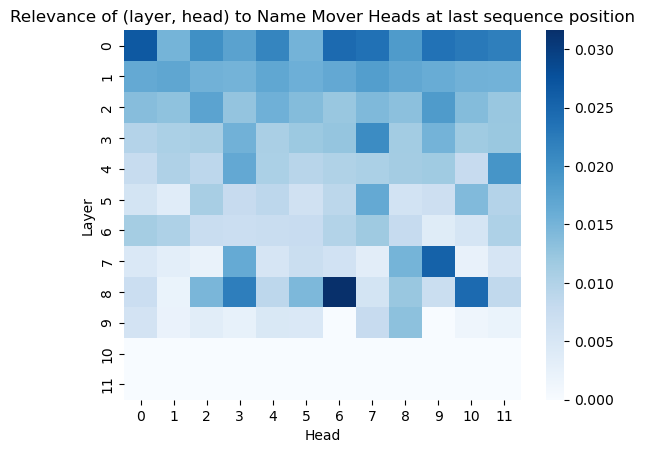

In [29]:
s = sns.heatmap(decomp_scores[:, ioi_dataset.word_idx['end'][0], :], xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of (layer, head) to Name Mover Heads at last sequence position")
plt.show()

In [65]:
results.sort(key=operator.attrgetter('score'), reverse=True)
outliers = results[:6] # hardcoded first few N
outliers_per_iter.append(outliers)
target_nodes = [r.ablation_set[0] for r in outliers] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else
print(target_nodes)
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets) 

[Node(layer_idx=0, sequence_idx=0, attn_head_idx=10), Node(layer_idx=0, sequence_idx=0, attn_head_idx=1), Node(layer_idx=0, sequence_idx=0, attn_head_idx=0), Node(layer_idx=0, sequence_idx=0, attn_head_idx=7), Node(layer_idx=0, sequence_idx=0, attn_head_idx=3), Node(layer_idx=0, sequence_idx=0, attn_head_idx=9)]


TypeError: can only concatenate list (not "TargetNodeDecompositionList") to list

In [33]:
print(len(target_decomps))
print((abs(target_decomps[0].rels[0])))

2304
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')


## New algorithm (fixed number of nodes per layer, weight relevance to the nodes according to the nodes' relevance in the previous iter, take nodes with highest absolute scores)

There are two problems with this algorithm generally:

1. The "relevance to logits" score isn't on the same scale as "relevance to target nodes" score, so there's no principled way to decide whether nodes in the last layer are more or less relevant than others.

2. More fatally, the most important nodes converge to position 0.

In [22]:
import functools
ranges = [
        [11],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]

# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
# for each source node determine the contribution of rel to the actual score

logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
full_score = io_logit - s_logit
assert(full_score > 0)

last_layer_results = []
Result = collections.namedtuple('Result', ('ablation_set', 'score'))

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    #print(score, rel_io_logit, rel_s_logit)
    norm_score = score / full_score
    last_layer_results.append(Result(decomp.ablation_set, norm_score))


Running inputs 0 to 64 (of 192)
Running inputs 64 to 128 (of 192)
Running inputs 128 to 192 (of 192)


In [23]:
last_layer_results.sort(key=operator.attrgetter('score'), reverse=True)
last_layer_results[:6]

[Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=0),), score=0.0627064),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=6),), score=0.0623091),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=2),), score=0.049144655),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=3),), score=0.04818679),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=7),), score=0.04440797),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=11),), score=0.0425904)]

In [24]:
last_layer_results.sort(key=operator.attrgetter('score'), reverse=True)
outliers = last_layer_results[:6] # hardcoded first few N
outliers_per_iter = [outliers]
node_weights = [r.score for r in outliers]

for layer in range(10, -1, -1):
    target_nodes = [r.ablation_set[0] for r in outliers] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else
    sum_scores = sum([r.score for r in outliers])
    node_weights = [r.score / sum_scores for r in outliers]
    print("layer %d: " % layer)
    print("new target nodes:")
    print(target_nodes)
    ranges = [
            [layer],
            [sequence_position for sequence_position in range(input_shape[1])],
            [attention_head_idx for attention_head_idx in range(12)]
        ]

    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes]

    prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    _, target_decomps = batch_run(prop_fn, ablation_sets) # why does this run so slowly? is it because moving target decomps is slow or something?

    results = []
    for target_decomp in target_decomps:
        # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
        score = 0
        for i in range(len(target_decomp.target_nodes)):
            weight = node_weights[i]
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score * weight)
        results.append(Result(target_decomp.ablation_set, score))
    results.sort(key=operator.attrgetter('score'), reverse=True)
    outliers = results[:6] # hardcoded first few N
    outliers_per_iter.append(outliers)


layer 10: 
new target nodes:
[Node(layer_idx=11, sequence_idx=14, attn_head_idx=0), Node(layer_idx=11, sequence_idx=14, attn_head_idx=6), Node(layer_idx=11, sequence_idx=14, attn_head_idx=2), Node(layer_idx=11, sequence_idx=14, attn_head_idx=3), Node(layer_idx=11, sequence_idx=14, attn_head_idx=7), Node(layer_idx=11, sequence_idx=14, attn_head_idx=11)]
Running inputs 0 to 64 (of 192)
Running inputs 64 to 128 (of 192)
Running inputs 128 to 192 (of 192)
layer 9: 
new target nodes:
[Node(layer_idx=10, sequence_idx=9, attn_head_idx=0), Node(layer_idx=10, sequence_idx=9, attn_head_idx=6), Node(layer_idx=10, sequence_idx=9, attn_head_idx=10), Node(layer_idx=10, sequence_idx=9, attn_head_idx=7), Node(layer_idx=10, sequence_idx=9, attn_head_idx=1), Node(layer_idx=10, sequence_idx=9, attn_head_idx=2)]
Running inputs 0 to 64 (of 192)
Running inputs 64 to 128 (of 192)
Running inputs 128 to 192 (of 192)
layer 8: 
new target nodes:
[Node(layer_idx=9, sequence_idx=2, attn_head_idx=0), Node(layer_idx

In [26]:
# for outs in outliers_per_iter:
#     print([r.score for r in outs])

all_outliers = sum(outliers_per_iter, [])
print(all_outliers[0])
print(len(all_outliers))

Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=0),), score=0.0627064)
72


In [27]:
all_outliers.sort(key=operator.attrgetter('score'), reverse=True)
for x in range(25):
    print(all_outliers[x])

Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=1),), score=tensor(0.0721, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=3),), score=tensor(0.0670, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=0),), score=0.0627064)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=6),), score=0.0623091)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=4),), score=tensor(0.0588, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=5),), score=tensor(0.0584, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=2),), score=0.049144655)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=3),), score=0.04818679)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=7),), score=0.04440797)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx

# Relevance of nodes to query vectors of known name mover heads